# MDD 2022 Summer School: Data Security and Privacy for Outsourced Data in the Cloud (Lab Session)

Tristan Allard (Univ Rennes, CNRS, IRISA) & Amr El Abbadi (UC Santa Barbara)

_Acknowledgments to Louis Béziaud (Univ Rennes, CNRS, IRISA, UQÀM) and to Matthieu Simonin (INRIA)._

This work is licensed under a [Creative Commons Zero v1.0 Universal License](https://creativecommons.org/publicdomain/zero/1.0/)

# Step 0 (Starter)
<a id='step_0'></a>
This lab session is a lightweight introduction to <a href="https://hal.archives-ouvertes.fr/lirmm-01886725">PinedRQ</a> \[1\], an index over encrypted data designed so that probabilistic SIM-CDP, a computational variant of differential privacy, is satisfied. The notebook interface that you are currently reading will help you launch experiments and visualize the results. The metrics that we will monitor are `recall` and `precision` first (satisfying differential privacy leads to approximations in the query results), and time (encrypting records has an overhead).

\[1\] Cetin Sahin, Tristan Allard, Reza Akbarinia, Amr El Abbadi, Esther Pacitti. A Differentially Private Index for Range Query Processing in Clouds. 34th IEEE International Conference on Data Engineering (ICDE), Apr 2018, Paris, France. pp.857-868, ⟨10.1109/ICDE.2018.00082⟩.

## Step 1 (Technical preliminaries)
First, lets do some imports and setup the logger.

In [1]:
import logging

logging.basicConfig(level=logging.WARNING)

from itertools import product, groupby

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pinedrq


In [2]:
def random_query(frac: float, v_min: float, v_max: float):
    """
    Utility function for generating uniformly at random range queries.

    :param frac: Fraction of the domain considered.
    :param v_min: Min value of the domain.
    :param v_max: Max value of the domain
    """
    v_max -= 1 # We exclude the max element because it is not included in the leave.
    width = frac * (v_max - v_min)
    ge = np.random.randint(v_min, 1 + v_max - width)
    le = round(ge + width)
    return ge, le


def score(idx_pred: np.ndarray, idx_true: np.ndarray, ge: float, le: float):
    """
    Utility function for scoring the result of a query execution (recall and precision).

    :param idx_pred: The array of records retrieved through the cloud.
    :param idx_true: The array of records that would have been retrieved through the data manager (ground truth).
    :param ge: The lower bound of the range query (inclusive).
    :param le: The higher bound of the range query (inclusive).
    """

    tp = np.sum((idx_pred >= ge) & (idx_pred <= le))  # num true positives retrieved
    pp = len(idx_pred)  # total num records retrieved.
    pos = len(idx_true)  # total num of true positives in the ground truth.
    precision = tp / pp
    recall = tp / pos
    return precision, recall


def query_true(dm, ge, le):
    return dm.data[((dm.data[dm.index_col] >= ge) & (dm.data[dm.index_col] <= le))]

## Step 2 (Parameters)
We define below the number of repetitions per run that we will do and the parameters of the PinedRQ index. Do not hesitate to modify. You might need to modify the plots below in order to have a nice display.

In [3]:
repeats = 10  # num repeat each run

params = {
    "bins": [50],
    "degree": [5],
    "epsilon": np.logspace(start=-1, stop=2, num=4, endpoint=True),  # [10e-1 1 10e1 10e2]
    "proba_dp": np.linspace(start=0.5, stop=0.9, num=5, endpoint=True),  # [0.5 0.6 ... 0.9]
    "frac": [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
}

## Step 3 (Measure)
We are now ready to launch the experiments by using the parameters defined above.

In [4]:
%%time
def run():
    for dm_args, params_ in groupby(product(*params.values()), key=lambda x: x[:4]):
        dm = pinedrq.DemoManager(*dm_args)
        cloud = pinedrq.Cloud(dm.index)
        client = pinedrq.Client(cloud, dm.keychain, dm.index_col)

        bounds = dm.data[dm.index_col].min(), dm.data[dm.index_col].max()

        *_, fracs = zip(*params_)
        for frac in fracs:
            for _ in range(repeats):
                ge, le = random_query(frac, *bounds)

                res = client.query(ge, le)
                if res is not None:
                    idx_pred = res[dm.index_col]
                else:
                    idx_pred = np.empty(0)  # catch nothing returned

                precision, recall = score(idx_pred, query_true(dm, ge, le), ge, le)

                yield *dm_args, frac, precision, recall

df = pd.DataFrame(run(), columns=[*params.keys(), "precision", "recall"])

Clé : b'\xa9\xc0\xc6w^\xbcct\xe0\x99\xa3\xb0O\nX\xf9'
iVector : b'\xaeuU\x92l\xbd]\xcc&\x9b4\xf2\xdf\xb3\xcc>'
Perturbing the counts with epsilon = 0.1
Scale factors : [10.0, 20.0, 40.0, 80.0]
Levels : 4
Level: 1, Node's count : 945 perturbed by 2, new count : 947
Level: 1, Node's count : 712 perturbed by -20, new count : 692
Level: 1, Node's count : 1473 perturbed by -16, new count : 1457
Level: 1, Node's count : 765 perturbed by 18, new count : 783
Level: 1, Node's count : 1675 perturbed by 1, new count : 1676
Level: 1, Node's count : 841 perturbed by 8, new count : 849
Level: 1, Node's count : 1620 perturbed by 0, new count : 1620
Level: 1, Node's count : 867 perturbed by -14, new count : 853
Level: 1, Node's count : 1674 perturbed by -4, new count : 1670
Level: 1, Node's count : 888 perturbed by 2, new count : 890
Level: 1, Node's count : 1703 perturbed by 6, new count : 1709
Level: 1, Node's count : 886 perturbed by 4, new count : 890
Level: 1, Node's count : 876 perturbed by -11,

## Step 4 (Visualize and analyze)

Finally, we visualize the measures that we have just performed by printing and plotting them. Do not hesitate to change or add graphs that can assist you in your analysis.

In [5]:
df.describe() # Uncomment if you want to display general statistics about the results.

,bins,degree,epsilon,proba_dp,frac,precision,recall
count,1400.0,1400.0,1400.000000,1400.000000,1400.000000,1400.000000,1400.0
mean,50.0,5.0,27.775000,0.700000,0.444286,0.930649,1.0
std,0.0,0.0,41.893382,0.141472,0.344127,0.117288,0.0
min,50.0,5.0,0.100000,0.500000,0.010000,0.029851,1.0
25%,50.0,5.0,0.775000,0.600000,0.100000,0.916684,1.0
50%,50.0,5.0,5.500000,0.700000,0.400000,0.980940,1.0
75%,50.0,5.0,32.500000,0.800000,0.800000,0.998465,1.0
max,50.0,5.0,100.000000,0.900000,1.000000,1.000000,1.0


4*5


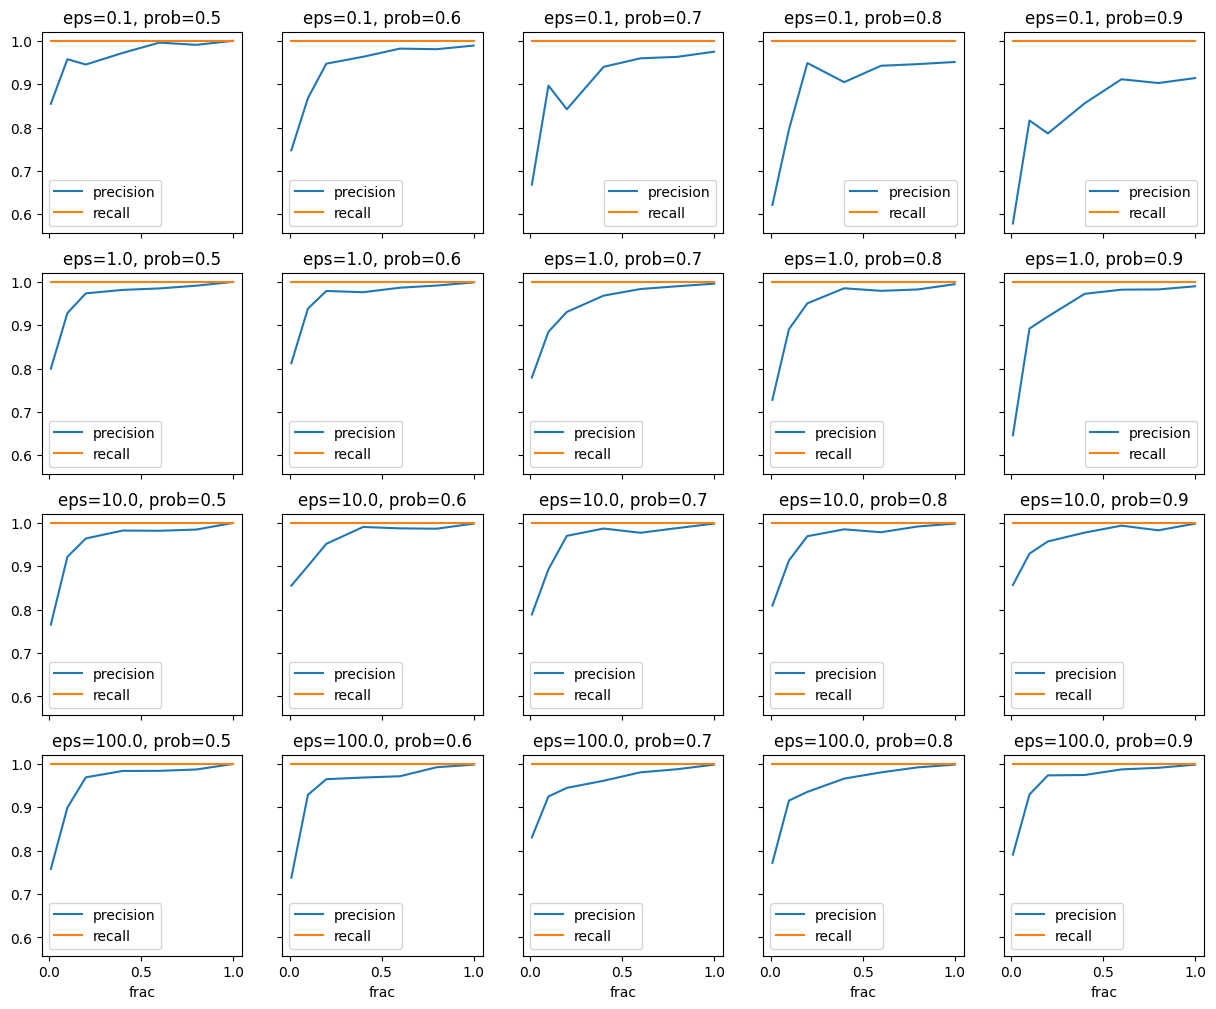

In [6]:
dfm = (
    df.groupby(["bins", "degree", "epsilon", "proba_dp", "frac"]).mean().reset_index(-1)
)

ncols = 5
nrows = dfm.index.nunique() // ncols
if dfm.index.nunique() % ncols > 0:
    nrows += 1

print(f"{nrows}*{ncols}")

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(3 * ncols, 3 * nrows), sharex=True, sharey=True
)

for ax, (gname, gdf) in zip(axes.flat, dfm.groupby(dfm.index)):
    ax.set_title(f"eps={gname[2]:.1f}, prob={gname[3]:.1f}")
    gdf.plot(x="frac", ax=ax, legend=True)

## Step 4 (Analysis)
Analyse the variations of your measures given the parameters under study. What are your conclusions ?


### Comparison between the naive approach and the improved approach

**Méthode naîve :**
<div>
    <table>
        <tr>
            <td><img src="img/perfMethodeNaive.png" width="500"/></td>
        </tr>
        <tr>
            <td><img src="img/statsMethodeNaive.png" width="500"/></td>
            <td><img src="img/grapheMethodeNaive.png" width="500"/></td>
        </tr>
    </table>
</div>

**Méthode ameliorée :**

<div>
    <table>
        <tr>
            <td><img src="img/perfMethodeAmelioree.png" width="500"/></td>
        </tr>
        <tr>
            <td><img src="img/statsMethodeAmelioree.png" width="500"/></td>
            <td><img src="img/grapheMethodeAmelioree.png" width="500"/></td>
        </tr>
    </table>
</div>

Tout d'abord nous remarquons une amelioration significative dans la performance. Le temps d'exécution de la première approche est d'environ 1m30s tandis que le temps d'exécution de l'approche ameliorée est d'environ 50s.

De plus, nous pouvons remarquer une différence significative dans la précision entre l'approche naîve et l'approche améliorée. La précision moyenne est passée de 0,46 dans l'approche naïve à 0,93 dans l'approche améliorée. La valeur minimale de la précision est également beaucoup plus élevée avec l'approche améliorée, ce qui montre que les résultats sont plus stables. 

En outre, le "recall" reste constante à 1 pour les deux approches, ce qui indique que les deux requêtes sont capables d'identifier correctement toutes les données se situant dans les intervalles donnés. Cela est representé dans les courbes.

La méthode query développée pour améliorer les résultats de la requête naïve permet donc une meilleure précision dans le retour des requêtes en retournant des résultats pertinents à plus de 90% avec des performances à l'exécution bien supérieure.

## Tests 


In [7]:
%run pinedrq.py

In [8]:
#Test Q12
test = Keychain()
#test.generate_key()
#test.generate_iVector()

Clé : b'\xc4)\x9cc,9N\x1f\xe4\x93\x83R<\x97\x99\xcd'
iVector : b'8\xc2\xbcK\xa6eo\x97\x10\xb5\x81tn\xbcH\xbc'


In [9]:
#Test Q13 et Q14
message = "Message secret"
keychain = Keychain()
encrypted_message = keychain.encrypt(message.encode())
print('Message chiffré : '+ str(encrypted_message))
decrypted_message = keychain.decrypt(encrypted_message)
print('Message dechiffré : '+ str(decrypted_message))

Clé : b'\x05\x08\x13\xeb\xd4g\x1eu&\xc5\xa4\x03_\xa74&'
iVector : b'$\x839YH\xa8\xec\xc5\x11\x87Vz=\xbfA\xc7'
Message chiffré : b'\x01\x18\rf\xcb\xab\xabH\xb2\xc1\x01\xa8\x8b\x11\xaf\x12'
Message dechiffré : b'Message secret'


In [10]:
# Réponse à la Q16

params2 = {
    "bins": [3],
    "degree": [5],
    "epsilon": 0.1,
    "proba_dp": np.linspace(start=0.5, stop=0.9, num=4, endpoint=True),  # [0.5 0.6 ... 0.9]
    "frac": [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
}

data_array = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

index=Index(keychain, data_array, 0, params2["bins"][0], params2["degree"][0], params2["epsilon"], params2["proba_dp"][3], 1)
#index = Index(keychain, data=data_array, encrypted_message, bins=params["bins"][0], degree=params["degree"][0], epsilon=params["epsilon"][3], proba_dp=params["proba_dp"][3], dummy_value=1)#index._perturb_histogram()

Perturbing the counts with epsilon = 0.1
Scale factors : [10.0, 20.0]
Levels : 2
Level: 1, Node's count : 1 perturbed by -10, new count : 0
Level: 1, Node's count : 1 perturbed by 8, new count : 9
Level: 1, Node's count : 1 perturbed by 1, new count : 2
Level: 2, Node's count : 3 perturbed by 24, new count : 27
type(keychain)= <class 'type'>
type(data)= <class 'numpy.ndarray'>
type(index)= <class 'numpy.ndarray'>
type(root)= <class '__main__.Node'>
type(proba_dp)= <class 'numpy.float64'>
type(epsilon)= <class 'float'>
type(nlevels)= <class 'int'>
type(dummy_value)= <class 'int'>


In [12]:
# Test Q22
index.query(-3,3)



[Bucket(records=b'\x1d]\x8b,g\xd1R\xeb\xcf\x03\xf5\xacd^\x815', overflow=b'\x8c\'\xf2\xaa\xf9p\xfa\x8bv\xd0\x91\x92\xe7\xf8\xc3\xc1p\xa5_\x85j\x0eT\xa9H\xc3\xcf2\xc6\x036\xd0B~f\xe6I?\\x\'&s\xea\xe7\x89{Qq\xf6\x19\x04I\xdfU\xeb\x16\xc2[\xb1\x08\xa9\x8aE\x02\x8eO\x917O\x8b\xee\x88\xb5T\xe7,\xa9Q\x84y\xb5\xe2\xdca\\0u\xa7U\x9b\xbf4C\x9cn\xa0b()\x1f\xc7N\xd1\xf9\x96\xae\x9f|*\x94\x8e\x9d\xbf\x07\x80K\x9c\xcc\xc7\x81\xaf/k\x8c6\xc1\x16\xa0\x16\xe1i8\t\x16&\x8c\xfa\xd0\xcd\xbf\x82\xd4\xa9\xb5!\x8e\xcd\x12\x12\xa4+\n\x92\xdd\xcc\xaa\xd1\xbe\xd5\xcbL\x8a\x10t\xfe\x8d\x1b&\xaf\x85\x97\x99N\xe3\xb5\xf3\xc9\xe4\x1c\xe0\r|U\xd7s\xf4\xeb\x8c\x19\xf2\x0e\x9cW\xca\x94\x12\x8eZ\x18\xf8D\x08H\xea\x02\xde\x83\x8d:\xc8\xe7 0P}\xd3\x87\xc8\xb4\xc6\x01\xed\xab\xe1\xa4\x96=\xd1p\x96}\x06 Z\xd1l2\x9e\x9c:\xc6g\xe3\xbd\xf1\xb6= \'\x05\xe5\xbf\x94\x08\xaaT\xdbH\xbb\x8f\xbe\x8f\x94\x10\xe77\xe0\x06\xe0[\xc9\xda\xb5`\xc8\xae\x18wfF\x90\xf2\x81\xd5}BZc\xcaY\x9e\xd2R\x10\xc1\x82\x8dY\x10\xab\x18,\xc1\x91\xf9\r\xd

In [14]:
cloud=Cloud(index)

client=Client(cloud, keychain, 0)

client.query(-3,3)

array([1, 2, 3, ..., 1, 1, 1])